In [1]:
# %load libraries.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sk_som.sklearn_som.som import SOM
#from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
import clustering_module as cl
import seaborn as sns
#from sklearn.metrics import silhouette_samples, silhouette_score
from s_dbw import S_Dbw
#from collections import Counter
from sklearn.utils import shuffle
from sklearn.cluster import KMeans 
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
#from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from matplotlib import rc
from IPython.display import Image
from matplotlib.colors import LinearSegmentedColormap
from mycolorpy import colorlist as mcp
from matplotlib import cm
#import plotly as py
#from plotly.subplots import make_subplots
#import plotly.express as px
#import plotly.figure_factory as ff
#import plotly.graph_objs as go
#import plotly.graph_objects as go
from matplotlib.collections import LineCollection

import re 
import os
if not os.path.exists("images"): os.mkdir("images")

In [2]:
import random
#sns.set(rc={'figure.figsize':(10,5)})
#sns.set(rc={'figure.dpi':100})

%matplotlib inline 
#np.random.seed(42)

In [3]:
sdbw_metric = ["chebyshev","cityblock","cosine","euclidean"]

In [4]:
def sdbw_choice(X,highest,distances,type_model):
    
    '''
    Функция строит метрики оценки кластеров
    
    df - pd.DataFrame парметров
    highest- верхняя граница количества кластеров
    distances - list список метрик, согласно которой будет подбираться количество кластеров    
    type_model - str, 'som' or 'km' or 'agg'
    '''
    range_n_clusters = np.arange(2,highest,1)   

    fig = go.Figure()
    modes = 'markers+lines'  
    
    
    for d,dtem in enumerate(distances):
        SDbw = []
        #print(dtem)          
        for n_clusters in range_n_clusters:
            
            if type_model == 'som':
                model = SOM(m = n_clusters,
                            n = 1,
                            dim = 1,
                            random_state=42)
                model.fit(X[1].iloc[:,2].values.reshape(-1,1))
                predictions = model.predict(X[1].iloc[:,2].values.reshape(-1,1))
                                               
            if type_model == 'km':
                model_km = KMeans(
                    n_clusters=n_clusters,
                    tol=0.01,
                    n_init=500,
                    random_state=42)
                predictions = model_km.fit_predict(X[1].iloc[:,2].values.reshape(-1,1))  
                
            if type_model == 'agg':
                model_agl = AgglomerativeClustering(
                    n_clusters = n_clusters,
                    affinity = 'l1',
                    linkage='average')
                predictions = model_agl.fit_predict(X[1].iloc[:,2].values.reshape(-1,1))  
                

            score = S_Dbw(X[1].iloc[:,:2].values, 
                          predictions,
                          centers_id=None,
                          method='Halkidi',
                          alg_noise='comb',
                          centr='mean', 
                          nearest_centr=True,                     
                          metric = dtem)#'euclidean')
            
            SDbw.append(score)    
            print("Разбивка на " + str(n_clusters) +' кластера')
        print('Расчет с использованием метрики ',dtem, 'завершен!')
        y3 = SDbw
        
        fig.add_trace(
            go.Scatter(
                x = range_n_clusters,
                y = y3,
                #showlegend = False,
                name = 'SDbw  index for  ' + dtem,
                mode = modes,
                showlegend=True,
                #marker = dict(color = 'blue'),                
            )
        ) 
        
        fig.update_layout(
            #title = ' DISTANCE IS ' + dtem,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
    fig.show()
   

In [5]:
def prepation_data(X):
    
    area_df = pd.read_table("input/"+ X,sep=' ',header=None)
    X_NAME, Y_NAME, VAL = 'X','Y', 'VALUE'
    area_df.columns = [X_NAME, Y_NAME, VAL ]
    
    #predictions = cl.spectal_cluster(3,area_df.values)
    #area_df.VALUE = predictions[0].tolist()
    
    area_df[X_NAME] = area_df[X_NAME].astype('int32')
    area_df[Y_NAME] = area_df[Y_NAME].astype('int32')
    area_df[VAL] = area_df[VAL].astype('float32')
    
    print('Имена столбцов',area_df.columns.tolist())
    print()
    scenarios = area_df.columns[2:].tolist()
    print('Перечень признаков в датасете',scenarios)

    outcomes = area_df[scenarios].values.reshape(1,-1)[0]
    outcomes_vect = list(outcomes)
    sq_all = len(outcomes_vect)

    grid_df = pd.DataFrame(columns=['X', 'Y'])
    grid_df[X_NAME] = area_df[X_NAME].values
    grid_df[Y_NAME] = area_df[Y_NAME].values
    grid_df['outcomes'] = outcomes_vect

    table = grid_df.pivot(index=Y_NAME, columns=X_NAME, values='outcomes')
    table = table.fillna(-1)
    
    return table,grid_df    

In [6]:
def cmap_discretize(cmap, N):
    
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
        
    # Return colormap object.
    return LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [7]:
def build_map(prediction,X,name_of_map,isoline):
    sns.set(rc={'figure.dpi':150})
    sns.set(rc={'figure.figsize':(20,10)})
    
    labels = np.unique(predictions)   
    cmap = cmap_discretize(cm.Spectral, len(labels))
    fig, axes = plt.subplots(1,2)
    
    axes[0].contour(X[0],20,levels = isoline, colors='white')
    sns.heatmap(X[0],
                robust=True,
                cmap=cmap,
                #annot = True, 
                xticklabels =False,
                yticklabels =False,
                ax = axes[0]
               )
    axes[0].title.set_text('Clustered map of ' + name_of_map)   
    axes[0].invert_yaxis() 
    
    result = X[1][['outcomes']].copy()
    result['Cluster'] = prediction   
    sns.boxplot(data=result,
                y='outcomes',
                x = 'Cluster',
                hue='Cluster',
                palette=mcp.gen_color('Spectral', 4),
                dodge = True)   


In [8]:
#maps = ['Env']#,'Freq','H','Paleo']
#maps = ['Freq']
#maps = ['H']
maps = ['Paleo']

In [9]:
for item in maps:
    print(item)
    X = prepation_data(item)

Paleo
Имена столбцов ['X', 'Y', 'VALUE']

Перечень признаков в датасете ['VALUE']


In [ ]:
sdbw_choice(X,10,sdbw_metric,'agg')

In [10]:
n_clust = 4

model = SOM(m = n_clust,
            n = 1,
            dim = 1,
            random_state=42)
model.fit(X[1].iloc[:,2].values.reshape(-1,1))
predictions = model.predict(X[1].iloc[:,2].values.reshape(-1,1))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

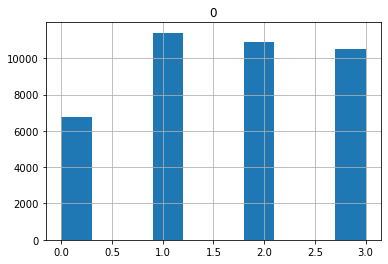

In [11]:
pd.DataFrame(predictions).hist()

In [ ]:
build_map(predictions,X,maps[0],[1000]) # 

In [ ]:
build_map(predictions,X,maps[0],[1000])

In [ ]:
build_map(predictions,X,maps[0],[0,5,15,25,35,40])

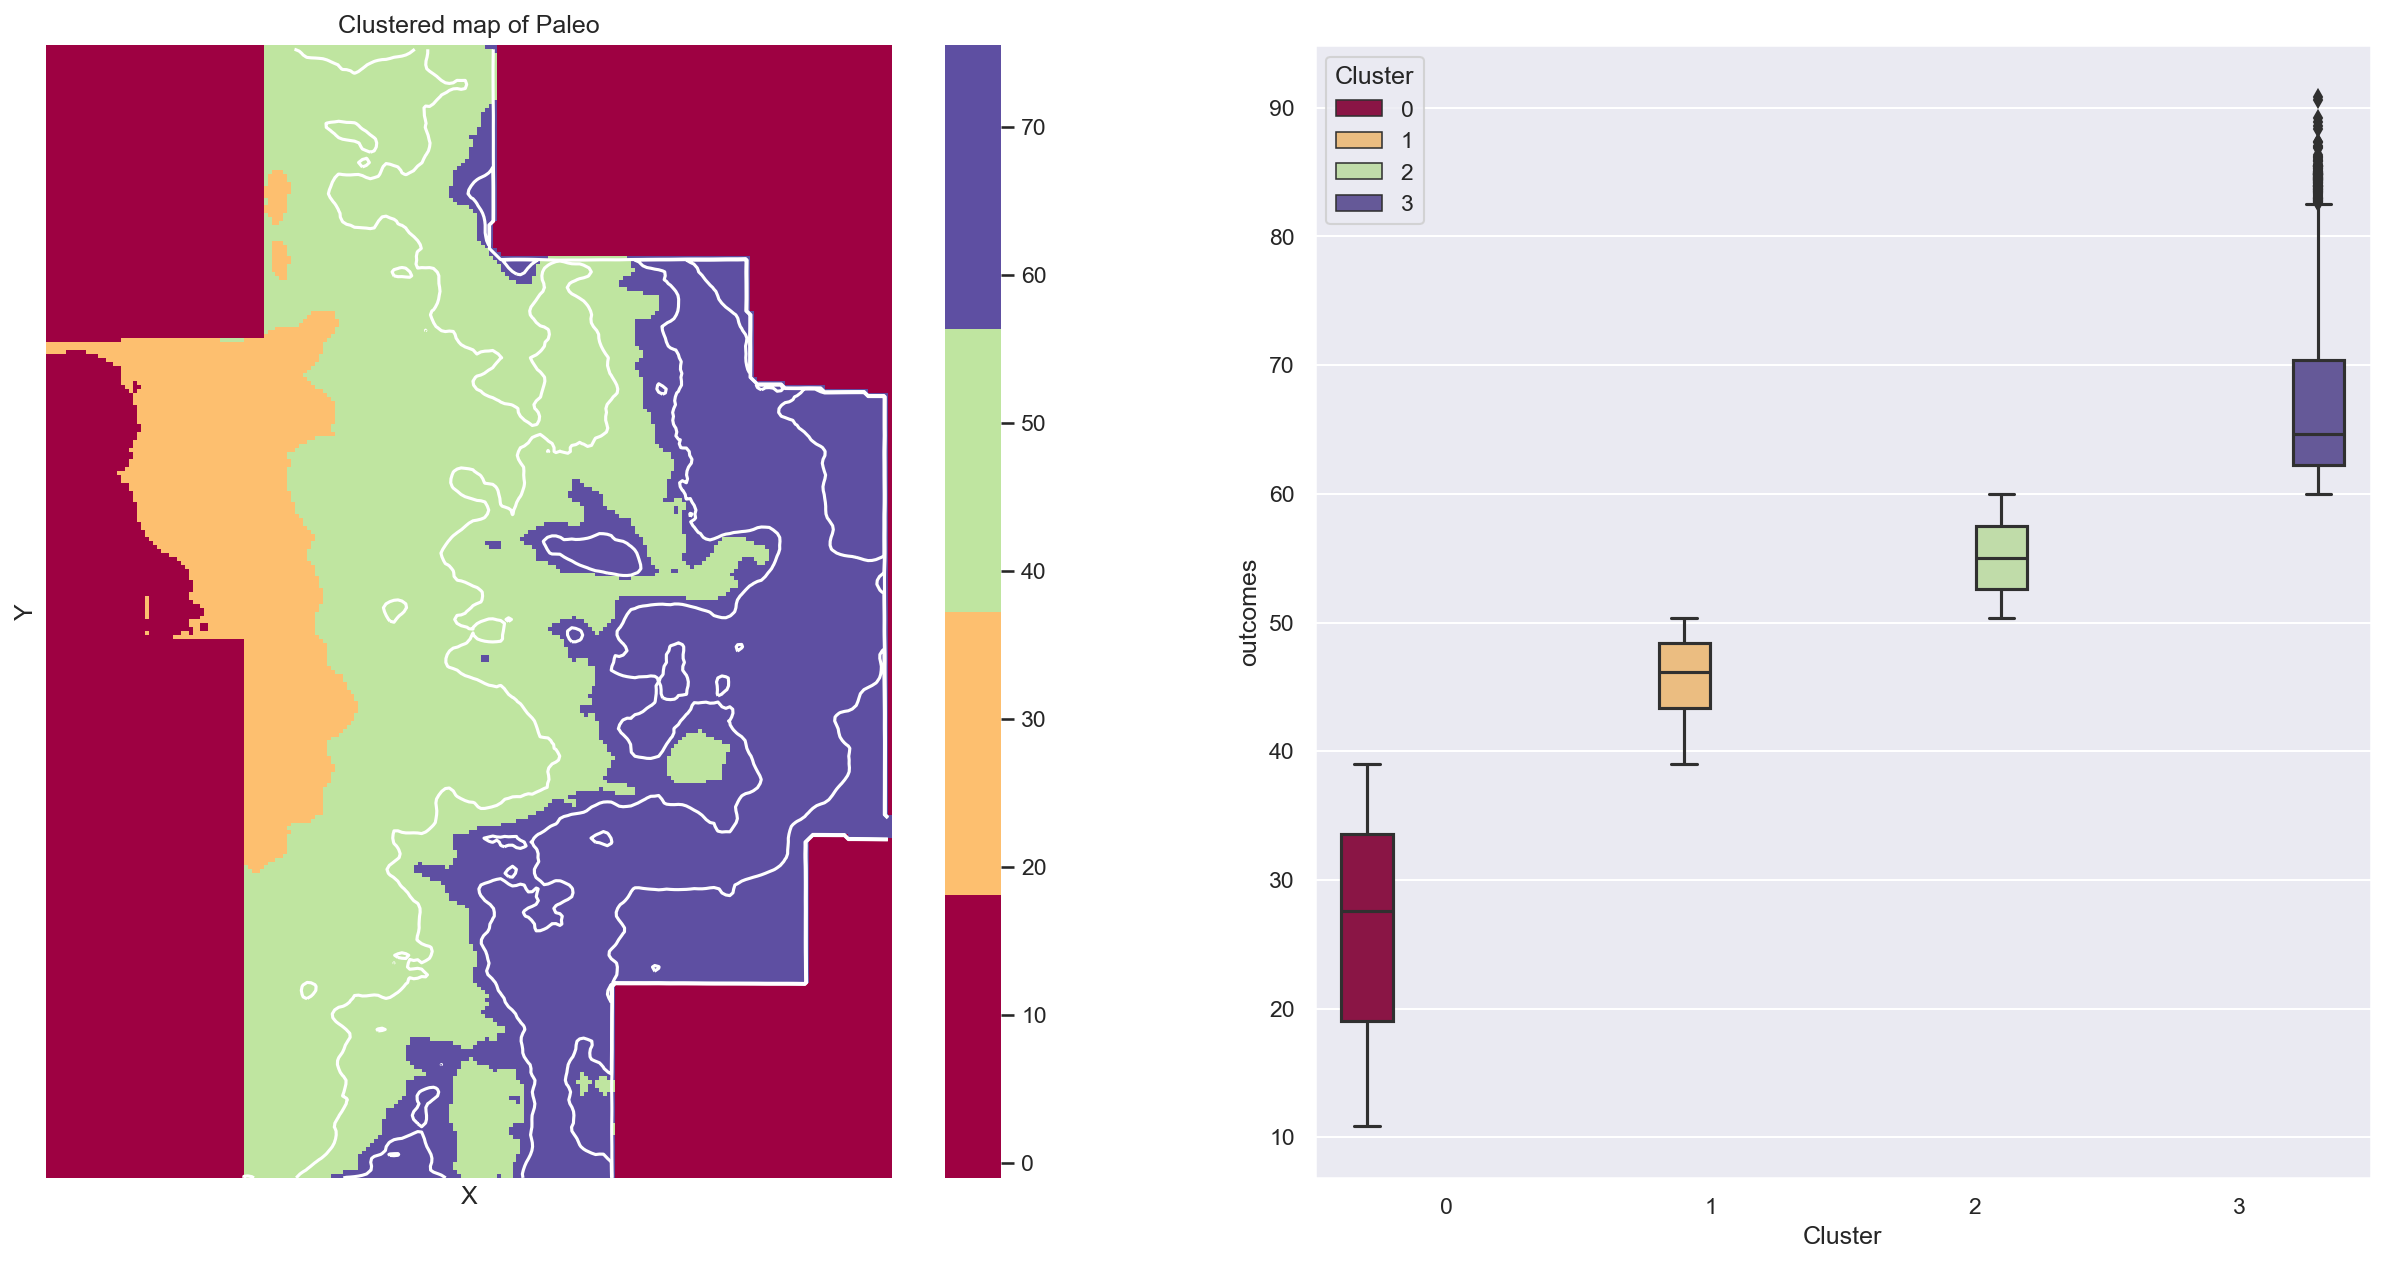

In [13]:
build_map(predictions,X,maps[0],[50,60,70])

In [ ]:
#maps = ['Env']#,'Freq','H','Paleo']
#maps = ['Freq']
#maps = ['H']
maps = ['Paleo']
for item in maps:
    print(item)
    X = prepation_data(item)

In [ ]:
sdbw_choice(X,10,sdbw_metric,'km')

In [ ]:
n_clust = 3

model_km = KMeans(
    n_clusters=n_clust,
    tol=0.01,
    n_init=500,
    random_state=42)

predictions = model_km.fit_predict(X[1].iloc[:,2].values.reshape(-1,1))  

In [ ]:
build_map(predictions,X,maps[0],[100]) # 

In [ ]:
build_map(predictions,X,maps[0],[100]) #

In [ ]:
build_map(predictions,X,maps[0],[0,5,15,25,35,40])

In [ ]:
build_map(predictions,X,maps[0],[10,20,30,40,50,60,70])

In [ ]:
maps = ['Env']#,'Freq','H','Paleo']
maps = ['Freq']
#maps = ['H']
#maps = ['Paleo']
for item in maps:
    print(item)
    X = prepation_data(item)

In [ ]:
sdbw_choice(X,10,sdbw_metric,'agg')

In [ ]:
n_clust = 5
'''
model_spec =  SpectralClustering(
    n_clusters=n_clust,
    affinity = 'nearest_neighbors',
    assign_labels='discretize',
    random_state=42)

predictions = model_spec.fit_predict(X[1].iloc[:,2].values.reshape(-1,1))  

'''

In [ ]:
#maps = ['Env']#,'Freq','H','Paleo']
#maps = ['Freq']
maps = ['H']
maps = ['Paleo']
for item in maps:
    print(item)
    X = prepation_data(item)

In [ ]:
sdbw_choice(X,10,sdbw_metric,'agg')

In [ ]:
n_clust = 6

model_agl = AgglomerativeClustering(
    n_clusters = n_clust,
    affinity = 'cityblock',
    linkage='average')

predictions = model_agl.fit_predict(X[1].iloc[:,2].values.reshape(-1,1))  

In [ ]:
build_map(predictions,X,maps[0],[100]) # 

In [ ]:
build_map(predictions,X,maps[0],[10]) #

In [ ]:
build_map(predictions,X,maps[0],[0,5,15,25,35,40])

In [ ]:
build_map(predictions,X,maps[0],[10,20,30,40,50,60,70])